In [10]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import json
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, classification_report
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("dummy_content_data.csv")

# Display first few rows
df.head()


,creator_id,content_id,license_type,usage_rights,content_platform,engagement_metrics,revenue_generated,royalty_payout,usage_timestamp,geographic_location,anomaly_flag,engagement_source,content_category
0,CR001,CNT101,Exclusive,Editorial,TikTok,"{'likes': 1804, 'comments': 297}",282.63,87.90,2024-09-25 03:29:29.759701,"Brisbane, Australia",True,Organic,Video
1,CR002,CNT102,Non-Exclusive,Commercial,Instagram,"{'likes': 606, 'comments': 106}",409.11,311.92,2025-02-12 03:29:29.759736,"Melbourne, Australia",True,Organic,Music
2,CR003,CNT103,Non-Exclusive,Editorial,TikTok,"{'likes': 1364, 'comments': 244}",99.04,842.86,2024-10-25 03:29:29.759741,"Perth, Australia",True,Paid,Music
3,CR004,CNT104,Exclusive,Editorial,TikTok,"{'likes': 1525, 'comments': 84}",692.30,174.07,2024-05-02 03:29:29.759746,"Melbourne, Australia",True,Paid,Music
4,CR005,CNT105,Non-Exclusive,Editorial,YouTube,"{'likes': 1401, 'comments': 48}",87.72,558.97,2024-11-03 03:29:29.759751,"Melbourne, Australia",False,Paid,Image


In [2]:
!pip install folium


     -------------------------------------- 110.9/110.9 kB 6.3 MB/s eta 0:00:00
     ---------------------------------------- 88.4/88.4 kB 4.9 MB/s eta 0:00:00
     -------------------------------------- 134.9/134.9 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3


In [5]:
!pip install prophet


     ---------------------------------------- 13.3/13.3 MB 8.6 MB/s eta 0:00:00
     ---------------------------------------- 94.5/94.5 kB 5.6 MB/s eta 0:00:00
     ------------------------------------- 863.9/863.9 kB 10.9 MB/s eta 0:00:00


In [7]:
!pip install prophet


In [11]:
# Convert engagement_metrics column from dictionary to separate columns
df['likes'] = df['engagement_metrics'].apply(lambda x: eval(x).get('likes', 0))
df['comments'] = df['engagement_metrics'].apply(lambda x: eval(x).get('comments', 0))

# Drop original engagement_metrics column
df.drop(columns=['engagement_metrics'], inplace=True)

# Convert usage_timestamp to datetime
df['usage_timestamp'] = pd.to_datetime(df['usage_timestamp'])

# Extract time-based features
df['hour'] = df['usage_timestamp'].dt.hour
df['weekday'] = df['usage_timestamp'].dt.weekday
df['month'] = df['usage_timestamp'].dt.month

# Convert geographic location to broader region
df['state'] = df['geographic_location'].apply(lambda x: x.split(",")[-1].strip())

# Calculate engagement ratios
df['like_comment_ratio'] = df['likes'] / (df['comments'] + 1)  # Avoid division by zero
df['revenue_per_like'] = df['revenue_generated'] / (df['likes'] + 1) 

# Check final structure
df.head()


,creator_id,content_id,license_type,usage_rights,content_platform,revenue_generated,royalty_payout,usage_timestamp,geographic_location,anomaly_flag,engagement_source,content_category,likes,comments,hour,weekday,month,state,like_comment_ratio,revenue_per_like
0,CR001,CNT101,Exclusive,Editorial,TikTok,282.63,87.90,2024-09-25 03:29:29.759701,"Brisbane, Australia",True,Organic,Video,1804,297,3,2,9,Australia,6.053691,0.156582
1,CR002,CNT102,Non-Exclusive,Commercial,Instagram,409.11,311.92,2025-02-12 03:29:29.759736,"Melbourne, Australia",True,Organic,Music,606,106,3,2,2,Australia,5.663551,0.673987
2,CR003,CNT103,Non-Exclusive,Editorial,TikTok,99.04,842.86,2024-10-25 03:29:29.759741,"Perth, Australia",True,Paid,Music,1364,244,3,4,10,Australia,5.567347,0.072557
3,CR004,CNT104,Exclusive,Editorial,TikTok,692.30,174.07,2024-05-02 03:29:29.759746,"Melbourne, Australia",True,Paid,Music,1525,84,3,3,5,Australia,17.941176,0.453670
4,CR005,CNT105,Non-Exclusive,Editorial,YouTube,87.72,558.97,2024-11-03 03:29:29.759751,"Melbourne, Australia",False,Paid,Image,1401,48,3,6,11,Australia,28.591837,0.062568


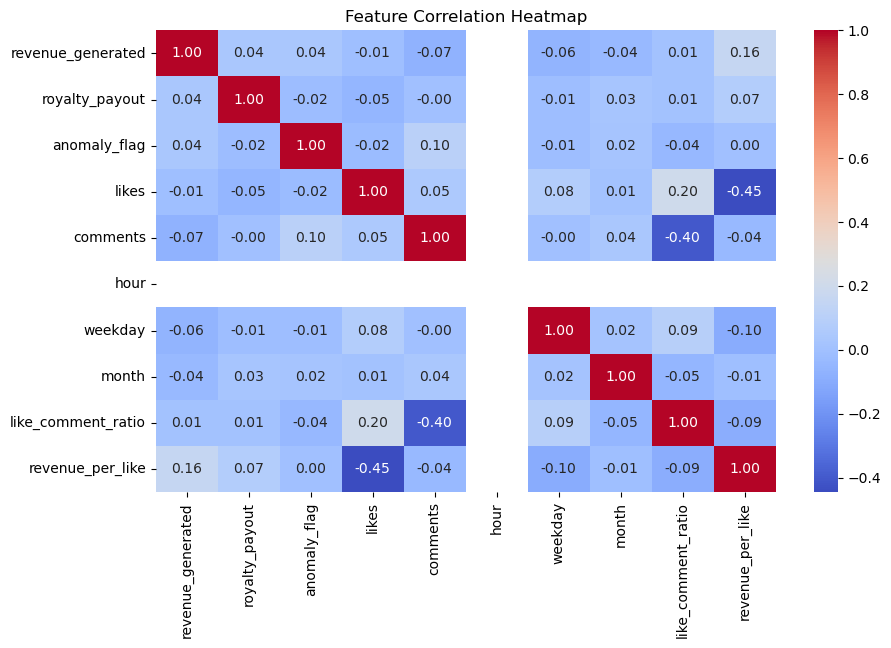

In [12]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


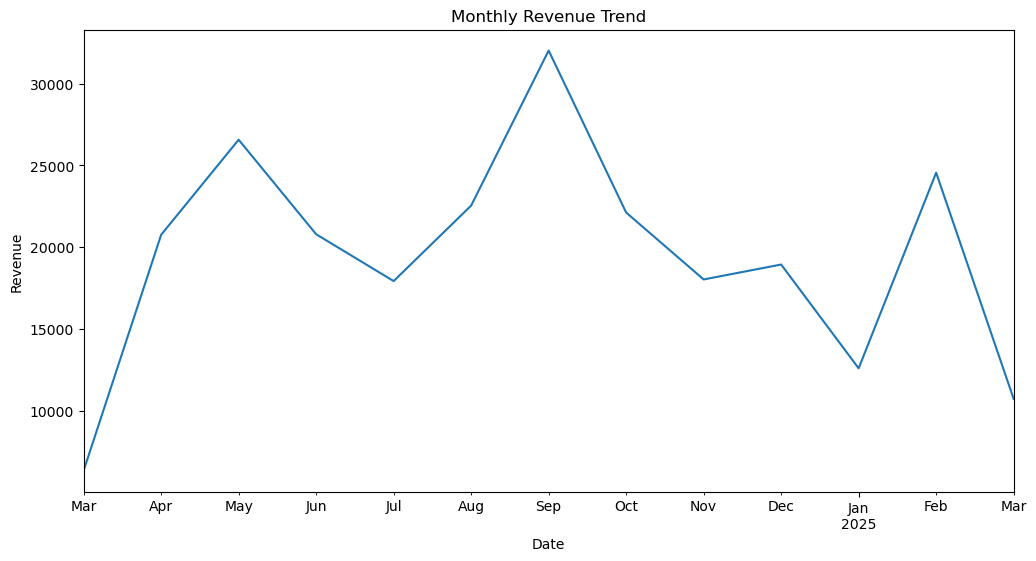

In [13]:
df.set_index("usage_timestamp")['revenue_generated'].resample("M").sum().plot(figsize=(12,6))
plt.title("Monthly Revenue Trend")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()


In [19]:
# Create a base map
m = folium.Map(location=[-25.2744, 133.7751], zoom_start=4)  # Centered on Australia

# Add markers for content locations
for index, row in df.iterrows():
    folium.Marker(
        location=[np.random.uniform(-38, -25), np.random.uniform(113, 153)],  # Randomized Australian coordinates
        popup=f"Content ID: {row['content_id']}\nEngagement: {row['likes']} likes, {row['comments']} comments"
    ).add_to(m)

m  # Display map


In [15]:
# Select features and target
X = df[['likes', 'comments', 'hour', 'weekday', 'month']]
y = df['revenue_generated']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict revenue
y_pred = model.predict(X_test)

# Evaluate model
print("Model Score:", model.score(X_test, y_test))


Model Score: -0.19617796112901686


In [16]:
# Select features and target
X = df[['likes', 'comments', 'hour', 'weekday', 'month']]
y = df['content_category']

# Convert categorical target to numeric
y = pd.factorize(y)[0]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Predict
y_pred = gb_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.33
              precision    recall  f1-score   support

           0       0.37      0.39      0.38        36
           1       0.30      0.34      0.32        29
           2       0.31      0.26      0.28        35

    accuracy                           0.33       100
   macro avg       0.33      0.33      0.33       100
weighted avg       0.33      0.33      0.33       100



In [17]:
# Train One-Class SVM
svm_model = OneClassSVM(nu=0.05, kernel="rbf")
df['fraud_score'] = svm_model.fit_predict(df[['likes', 'comments', 'revenue_generated']])

# Display flagged anomalies
df[df['fraud_score'] == -1]


,creator_id,content_id,license_type,usage_rights,content_platform,revenue_generated,royalty_payout,usage_timestamp,geographic_location,anomaly_flag,...,content_category,likes,comments,hour,weekday,month,state,like_comment_ratio,revenue_per_like,fraud_score
15,CR016,CNT116,Non-Exclusive,Editorial,YouTube,939.51,52.49,2024-04-16 03:29:29.759807,"Perth, Australia",False,...,Video,1971,91,3,1,4,Australia,21.423913,0.476425,-1
24,CR025,CNT125,Non-Exclusive,Commercial,TikTok,877.96,440.57,2024-09-02 03:29:29.759847,"Perth, Australia",True,...,Image,122,9,3,0,9,Australia,12.200000,7.137886,-1
50,CR051,CNT151,Non-Exclusive,Editorial,TikTok,749.10,860.87,2024-04-03 03:29:29.759990,"Perth, Australia",False,...,Image,25,93,3,2,4,Australia,0.265957,28.811538,-1
78,CR079,CNT179,Exclusive,Commercial,Instagram,106.33,466.34,2024-04-19 03:29:29.760128,"Brisbane, Australia",False,...,Image,1956,10,3,4,4,Australia,177.818182,0.054333,-1
80,CR081,CNT181,Non-Exclusive,Editorial,TikTok,159.84,403.94,2025-01-13 03:29:29.760138,"Perth, Australia",True,...,Music,26,44,3,0,1,Australia,0.577778,5.920000,-1
102,CR103,CNT203,Exclusive,Editorial,TikTok,12.59,240.47,2025-03-02 03:29:29.760234,"Melbourne, Australia",True,...,Video,470,39,3,6,3,Australia,11.750000,0.026730,-1
136,CR137,CNT237,Non-Exclusive,Commercial,YouTube,65.93,385.46,2024-09-27 03:29:29.760419,"Brisbane, Australia",False,...,Music,161,63,3,4,9,Australia,2.515625,0.406975,-1
159,CR160,CNT260,Non-Exclusive,Commercial,Instagram,202.83,862.10,2024-11-24 03:29:29.760520,"Sydney, Australia",True,...,Video,71,83,3,6,11,Australia,0.845238,2.817083,-1
191,CR192,CNT292,Exclusive,Commercial,Instagram,980.53,870.03,2024-12-12 03:29:29.760679,"Perth, Australia",False,...,Music,1823,169,3,3,12,Australia,10.723529,0.537571,-1
210,CR211,CNT311,Exclusive,Commercial,YouTube,960.73,578.52,2024-05-12 03:29:29.760768,"Melbourne, Australia",False,...,Video,153,127,3,6,5,Australia,1.195312,6.238506,-1


10:17:57 - cmdstanpy - INFO - Chain [1] start processing
10:17:58 - cmdstanpy - INFO - Chain [1] done processing


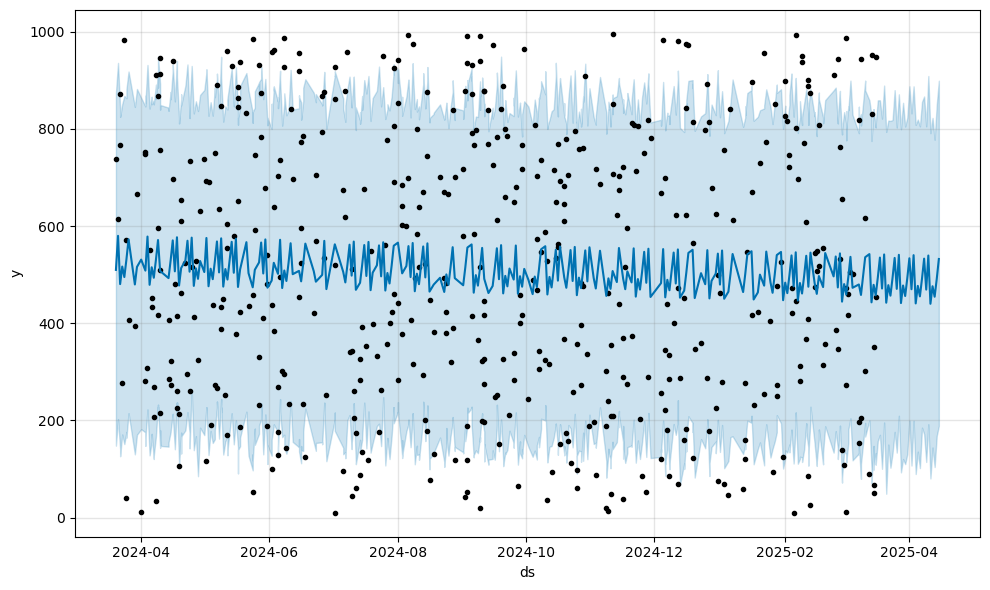

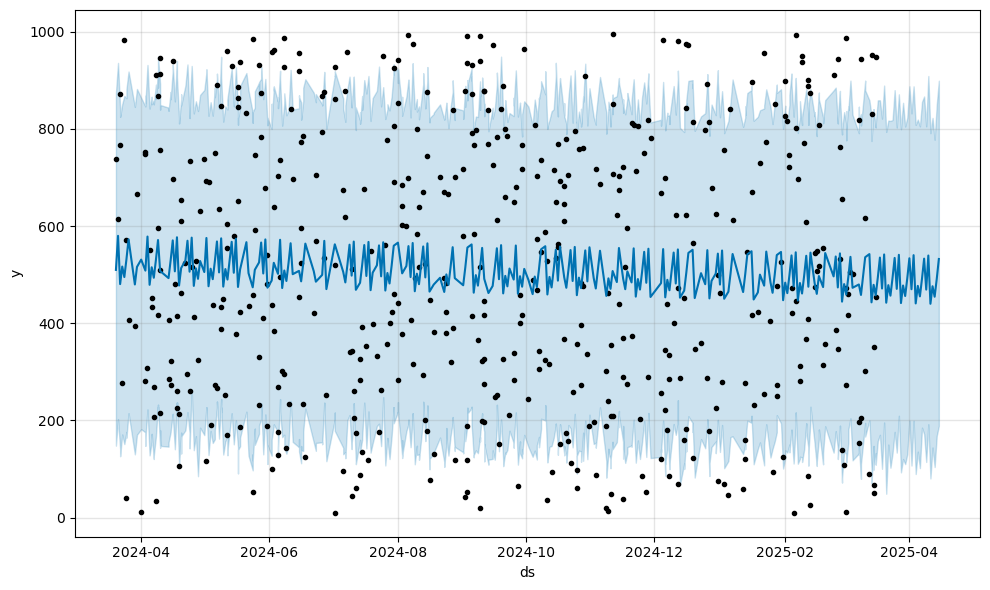

In [18]:
# Prepare dataset
df_forecast = df[['usage_timestamp', 'revenue_generated']].rename(columns={'usage_timestamp': 'ds', 'revenue_generated': 'y'})

# Train Facebook Prophet model
model = Prophet()
model.fit(df_forecast)

# Create future dataframe
future = model.make_future_dataframe(periods=30)

# Predict
forecast = model.predict(future)

# Plot
model.plot(forecast)
